# K-Means Clustering

This notebook implements the custom k-means clustering algorithm on the Wine dataset. Here, k-means clustering is used to discover clusters in dimensionality-reduced data without labels (unsupervised learning). The objective of this task is to validate the use of the custom k-means clustering algorithm, and evaluate its performance for a multi-feature clustering problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Wine dataset with relevant features
- Drops duplicates and missing data
- Performs PCA for dimensionality reduction
3. **Data Visualization**
- Visualizes the transformed data
4. **K-Means Implementation**
- Implements the custom-built k-means clustering algorithm on the data with two clusters
- Visualizes the results  
- Evaluates the results across multiple metrics  
5. **K-Means Implementation (Changing Parameters)**
- Implements the custom-built k-means algorithm with various numbers of clusters
- Examines the effect on model performance
6. **K-Means Implementation (Updated)**
- Implements the custom-built k-means clustering algorithm with the optimal number of clusters
- Visualizes the results
- Evaluates the results across multiple metrics
7. **Comparison with Existing Models**
- Runs the scikit-learn version of k-means clustering
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the k-means clustering algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run k-means clustering. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Sklearn 1.6.1

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rice_ml.preprocess import *
from rice_ml.unsupervised_learning.clustering import *
from rice_ml.unsupervised_learning.pca import *
from rice_ml.postprocess.unsupervised import *
import sklearn

### Data Loading and Cleaning
*Loading and preprocessing data*

The data used in this notebook comes from the Wine dataset. Although this dataset is typically used for either supervised regression or classification, it contains a fairly sizable number of features that make it suitable for clustering algorithms to explore relationships in the data. Additionally, it allows for several data cleaning steps that showcase the `rice_ml` preprocessing modules, as well as dimensionality reduction using the `PCA` class.

The data is first loaded as a Pandas DataFrame.

In [18]:
# Loading the data
wine_data = sklearn.datasets.load_wine(as_frame = True)
wine_data = wine_data.frame
display(wine_data)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


To ensure that the dataset does not contain missing data, we apply a series of preprocessing steps using functions from the `preprocess` package, including dropping any rows with missing values or that are identified to be duplicates of another. In addition, we drop the column with the *target* variable.

In [19]:
# Cleaning the data (removing missing data or duplicate rows)
wine_data_missing = missing_data(wine_data, 'drop')
wine_data_cleaned = duplicate_identify(wine_data_missing[:, :-1], True)

Because k-means clustering is an unsupervised learning technique, there is no meaningful distinction between the feature data and a target. Thus, the dataset does not need to be further divided. However, because there are many features in this set, we apply PCA with three components to reduce the dimensionality and facilitate analysis. For a comprehensive overview and example of PCA on the same dataset, see [this notebook](../pca/pca_example.ipynb).

In [20]:
# Applying PCA
pca = PCA(3)
pca.fit(wine_data_cleaned)
wine_data_pca = pca.transform(wine_data_cleaned)

### Data Visualization
*Data distribution plotting*

Once the data has been appropriately cleaned, we are able to visualize the transformed data in three-dimensional space. This allows us to determine whether the data shows preliminary clusters, and thus whether it is acceptable for k-means clustering.

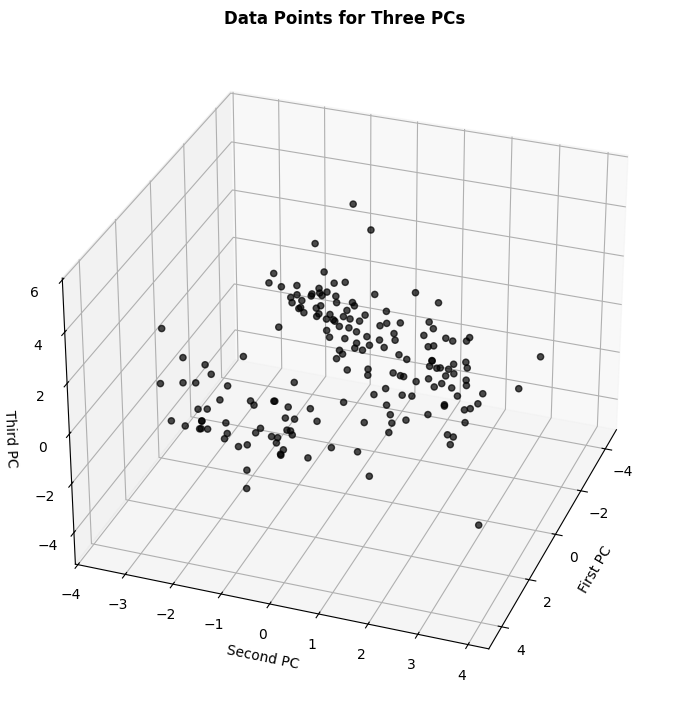

In [21]:
# Visualizing the transformed data
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], wine_data_pca[:, 2], c = 'black', alpha = 0.7)
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
ax.view_init(elev = 30, azim = 20)
fig.tight_layout()
plt.title("Data Points for Three PCs", fontweight = 'bold')
plt.show()

From this plot, several clusters appear to be present in the data that might be detected using k-means clustering.

### K-Means Implementation
*Clustering using k-means clustering*

This section implements k-means clustering on the cleaned and transformed wine data to produce a set of clusters that adequately group samples. It carries out the model fit, labeling, visualization, and evaluation on several metrics.

The transformed data does not need to be further standardized, nor does it need to be split for unsupervised learning. We therefore begin by creating an instance of the `k_means` class from the unsupervised learning package, and fitting it on the data.

This k-means clustering algorithm has the following specifications:
- **Number of Clusters:** 2
- **Maximum Iterations:** 100
- **Tolerance:** 1e-6
- **Random State:** 438

In [22]:
# Creating a k-means class and fitting it to the data
kmeans = k_means(2, 100, random_state = 438)
kmeans.fit(wine_data_pca)
labels = kmeans.cluster_labels

Once the model has been created and fit, we can visualize the resulting clusters and evaluate performance.

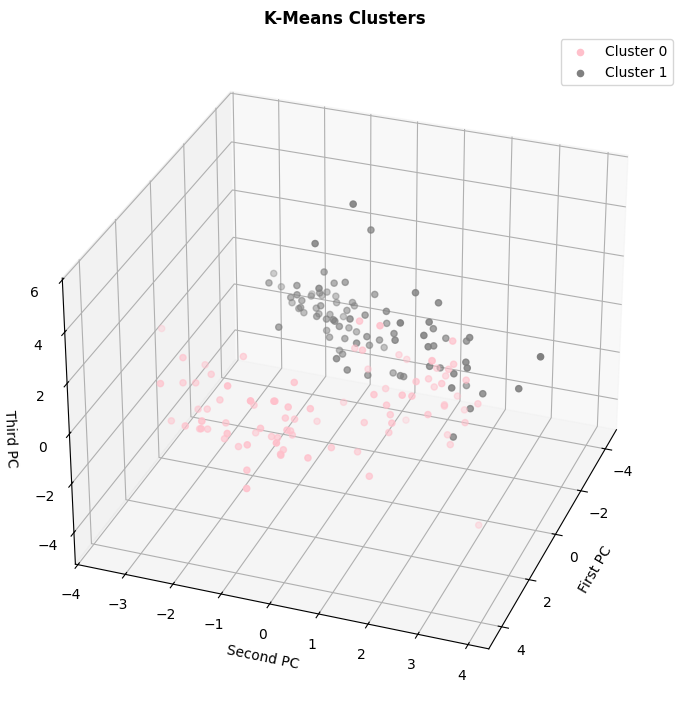

In [23]:
# Visualizing the transformed data with k-means clusters
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
label_to_color = {0: 'pink', 1: 'gray'}

for label in unique_labels:
    mask = (labels == label)
    color = label_to_color.get(label)  # fallback color just in case
    marker = 'o'
    
    ax.scatter(
        wine_data_pca[mask, 0],
        wine_data_pca[mask, 1],
        wine_data_pca[mask, 2],
        c = color,
        marker = marker,
        label = f'Cluster {label}'
    )
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")

ax.view_init(elev = 30, azim = 20)

ax.legend()
fig.tight_layout()

plt.title("K-Means Clusters", fontweight = 'bold')

plt.show()

The plotted data shows the distribution across two clusters, which intuitively appear to be a fairly suitable division of the data. Most points in the first cluster have higher scores on the first principal component, while most in the second have lower (more negative) scores. However, significant overlap exists between the two clusters. We can evaluate performance using a variety of evaluation metrics.

In [24]:
n_clusters, n_noise, counts = evaluate_clusters(labels)
sil_score_false = silhouette_score(wine_data_pca, labels, ignore_noise = True)
print(f"Silhouette score : {sil_score_false:.3f}")

Cluster Evaluation Metrics:
---------------------------
Number of clusters: 2
Number of noise points: No noise points
Cluster counts (including noise as -1):
  Cluster 1.0: 87 points
  Cluster 0.0: 91 points
Silhouette score : 0.389


This algorithm returned two clusters, split fairly evenly across the data. The silhouette score for this model is around 0.41, which is not particularly high, and indicates that the clustering may not be the best fit for the data. We will attempt to change the number of clusters to determine whether this improves the score.

### K-Means Implementation (Changing Parameters)
*Altering number of clusters*

This section implements the custom k-means clustering algorithm on the transformed data, but systematically changes a parameter in the model to determine the effects on performance. It evaluates the model for different numbers of clusters, using silhouette score and inertia as the primary metrics.

In [25]:
# Arrays for cluster number, silhouette score, and inertia
cluster_array = np.arange(1, 11)
sil_scores_cluster = []
inertia_cluster = []

# Calculating silhouette scores and inertia for different numbers of clusters
for i in range(len(cluster_array)):
    kmeans = k_means(n_clusters = int(cluster_array[i]), max_iterations = 1000)
    kmeans.fit(wine_data_pca)
    labels = kmeans.cluster_labels
    inertia = kmeans.inertia_
    inertia_cluster.append(inertia)
    if i != 0:
        sil_score = silhouette_score(wine_data_pca, labels, ignore_noise = False)
        sil_scores_cluster.append(sil_score)

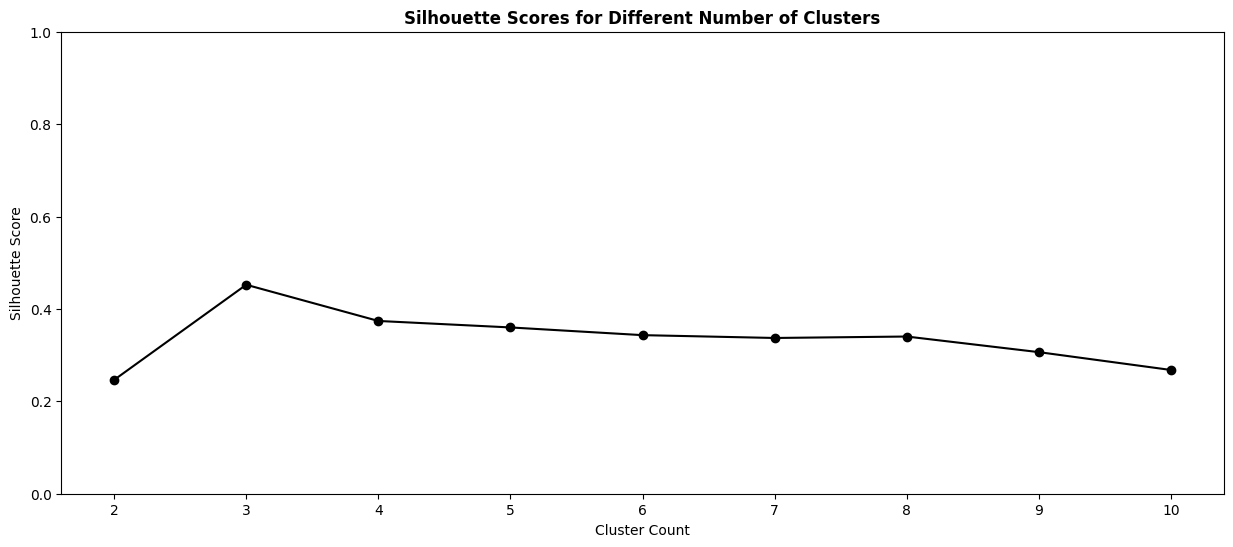

In [26]:
# Plotting the change in silhouette score across different cluster counts
plt.figure(figsize = (15, 6))
plt.plot(cluster_array[1:], sil_scores_cluster, 'black')
plt.scatter(cluster_array[1:], sil_scores_cluster, color = 'black')
plt.title("Silhouette Scores for Different Number of Clusters", fontweight = 'bold')
plt.xlabel("Cluster Count")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)
plt.show()

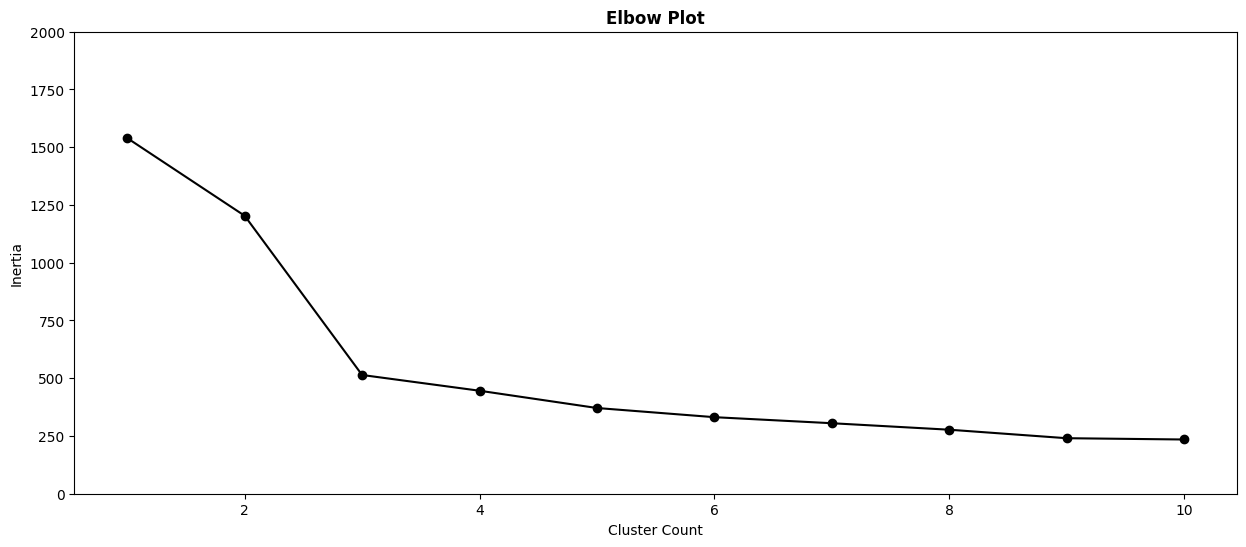

In [27]:
# Plotting the change in inertia across different cluster counts (elbow plot)
plt.figure(figsize = (15, 6))
plt.plot(cluster_array, inertia_cluster, 'black')
plt.scatter(cluster_array, inertia_cluster, color = 'black')
plt.title("Elbow Plot", fontweight = 'bold')
plt.xlabel("Cluster Count")
plt.ylabel("Inertia")
plt.ylim(0, 2000)
plt.show()

From the silhouette scores and the plot of inertia, three clusters appear to be the optimal number for this set. The silhouette score is greatest for this division, and the elbow plot indicates that increasing the number of clusters beyond this does not significantly lower inertia - the greatest drop occurs from one to three clusters, while it levels off for higher numbers. Thus, we will rerun the k-means algorithm with three clusters to assess the effect on performance.

### K-Means Implementation (Updated)
*Clustering using k-means with three clusters*

This section implements k-means clustering on the cleaned and transformed wine data to produce a set of three clusters that adequately group samples. It carries out the model fit, labeling, visualization, and evaluation on several metrics.

The transformed data does not need to be further standardized, nor does it need to be split for unsupervised learning. We therefore begin by again creating an instance of the `k_means` class from the unsupervised learning package, and fitting it on the data.

This k-means clustering algorithm has the following specifications:
- **Number of Clusters:** 3
- **Maximum Iterations:** 100
- **Tolerance:** 1e-6
- **Random State:** 438

In [28]:
# Creating a k-means class and fitting it to the data
kmeans = k_means(3, 1000)
kmeans.fit(wine_data_pca)
labels = kmeans.cluster_labels

Once the model has been fit, we visualize the transformed and clustered data in three-dimensional space, and evaluate it on a variety of model metrics.

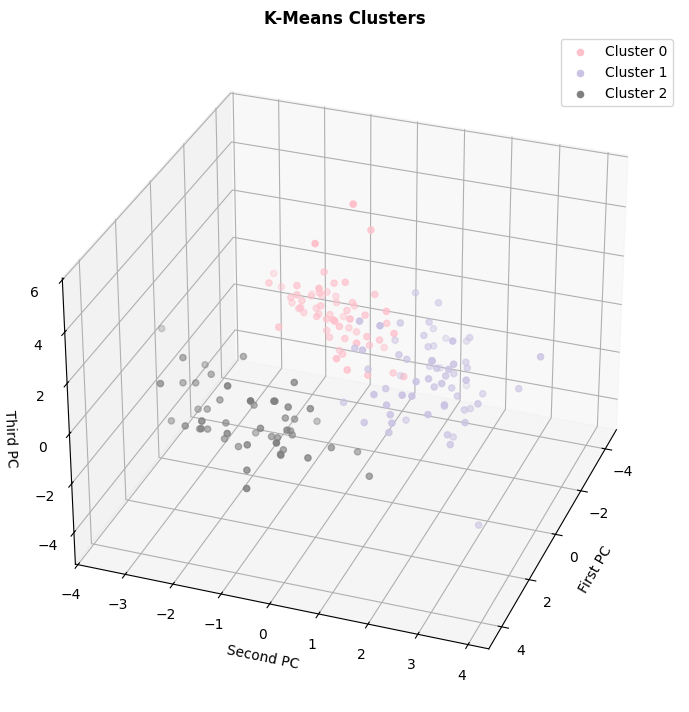

In [29]:
# Visualizing the transformed data with k-means clusters
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels)
label_to_color = {0: 'pink', 1: '#CBC3E3', 2: 'gray'}

for label in unique_labels:
    mask = (labels == label)
    color = label_to_color.get(label)  # fallback color just in case
    marker = 'o'
    
    ax.scatter(
        wine_data_pca[mask, 0],
        wine_data_pca[mask, 1],
        wine_data_pca[mask, 2],
        c = color,
        marker = marker,
        label = f'Cluster {label}'
    )
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")

ax.view_init(elev = 30, azim = 20)

ax.legend()
fig.tight_layout()

plt.title("K-Means Clusters", fontweight = 'bold')

plt.show()

In [30]:
# Evaluating the model
n_clusters, n_noise, counts = evaluate_clusters(labels)
sil_score_false = silhouette_score(wine_data_pca, labels, ignore_noise = True)
print(f"Silhouette score : {sil_score_false:.3f}")

Cluster Evaluation Metrics:
---------------------------
Number of clusters: 3
Number of noise points: No noise points
Cluster counts (including noise as -1):
  Cluster 0.0: 62 points
  Cluster 1.0: 65 points
  Cluster 2.0: 51 points
Silhouette score : 0.454


Using three clusters improves the silhouette score, and results in a fairly even division of the data across clusters. From the plot of the data, they appear to be relatively adequate and intuitive clustering patterns for the transformed data. Although the silhouette score is not particularly high, the k-means algorithm is able to perform effective clustering given the set of input features.

### Comparison with Existing Models
*Comparison with scikit-learn k-means*

In order to ensure that the custom-built k-means algorithm is functioning as intended and providing expected results, it is useful to compare its performance to k-means clustering performed using established code. In this section, we rerun the analysis with all features using the scikit-learn k-means class with a matching number of clusters (3) and iterations (10) to verify the results of the custom model.


In [31]:
# Creating an sklearn k-means cluster
from sklearn.cluster import KMeans
kmeans_sk = KMeans(n_clusters = 3, max_iter = 100, random_state = 438)
kmeans_sk.fit(wine_data_pca)
labels_sk = kmeans_sk.labels_

In [32]:
# Evaluating the model
n_clusters, n_noise, counts = evaluate_clusters(labels_sk)
sil_score_true = silhouette_score(wine_data_pca, labels_sk, ignore_noise = True)
print(f"Silhouette score: {sil_score_true:.3f}")

Cluster Evaluation Metrics:
---------------------------
Number of clusters: 3
Number of noise points: No noise points
Cluster counts (including noise as -1):
  Cluster 0.0: 63 points
  Cluster 2.0: 64 points
  Cluster 1.0: 51 points
Silhouette score: 0.453


The scikit-learn k-means results exactly match those of the custom class. Although the silhouette score remains low, this is more indicative of data that does not have well-defined clusters rather than an error in the custom k-means implementation. Thus, the custom `rice_ml` k-means clustering is able to handle multi-feature clustering problems in a manner that matches professional-level code.